In [2]:
### Load PPS model
%run ./HC_NS_model.ipynb

In [4]:
## Experiment function
def experimentrun_explore(v_distances, time, b, g, L_ex, L_in, S_ex, S_in, B_0):
    """Compute the multisensory facilitation effect for the given distance points.

    Args:
        v_distances (1D array): Vector with the distances at which the visual stimuli is delivered (cm).
        time (number): Running time of the experiment (ms).
        b (number): Bias introduced to unisensory neurons.
        g (number): Multisensory gain.
        L_ex (number): Amplitude of excitatory synapses to be used in unisensory areas.
        L_in (number): Amplitude of inhibitory synapses to be used in unisensory areas.
        S_ex (number): Extension of excitatory synapses (cm) to be used in unisensory areas.
        S_in (number): Extension of inhibitory synapses (cm) to be used in unisensory areas.
        B_0 (number): Maximum value of the feedback synapses.

    Returns:
        multi_RTs (1D np.array): Vector with the multisensory facilitation RTs at the given distance points (ms).
        ZMs (2D np.array): Matrix with the activity of the multisensory neuron during the experiment at each distance point.
        ZTs (3D np.array): Array with the final activity of the tactile neurons at each distance point.
        ZVs (3D np.array): Array with the final activity of the visual neurons at each distance point.
    """

    # Setup network synapses
    Wt, Wv, Bt, Bv = Fw(1.3, 1.3, B_0, B_0)
    Lt, Lv = Lw(L_ex, L_in, S_ex, S_in, L_ex, L_in, S_ex, S_in)

    # Include a unisensory measurement in the experiment
    v_distances = np.insert(v_distances.astype("object"), 0, "uni")

    # Network computing parameters
    dt = 0.4
    dtau = dt / tau

    # Experiment parameters
    timesteps = int(time / dt)
    ndist = len(v_distances)

    # Build matrices to register network activity during the experiment
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt, Nt, ndist))
    ZVs = np.zeros((Mv, Nv, ndist))

    qt = np.zeros((Mt, Nt, timesteps + 1, ndist))
    ut = np.zeros((Mt, Nt, timesteps + 1, ndist))
    zt = np.zeros((Mt, Nt, timesteps + 1, ndist))
    pt = np.zeros((Mt, Nt, timesteps + 1, ndist))

    qv = np.zeros((Mv, Nv, timesteps + 1, ndist))
    uv = np.zeros((Mv, Nv, timesteps + 1, ndist))
    zv = np.zeros((Mv, Nv, timesteps + 1, ndist))
    pv = np.zeros((Mv, Nv, timesteps + 1, ndist))

    qm = np.zeros((timesteps + 1, ndist))
    um = np.zeros((timesteps + 1, ndist))
    zm = np.zeros((timesteps + 1, ndist))
    pm = np.zeros((timesteps + 1, ndist))

    rt = np.zeros((timesteps + 1, ndist))

    # Generate a tactile stimulus
    ti = PHIt()

    # Run the experiment
    for d in range(ndist):
        xv_0 = v_distances[d]  # Defines how far the light is presented.
        vi = PHIv(xv_0)  # Generates a visual stimulus.

        for i in range(timesteps):
            # Tactile activity
            ut[:, :, i + 1, d] = ti + LIt(zt[:, :, i, d], Lt) + bt(zm[i, d], Bt)
            qt[:, :, i + 1, d] = qt[:, :, i, d] + dtau * (
                -qt[:, :, i, d] + ut[:, :, i, d]
            )
            pt[:, :, i + 1, d] = psit(qt[:, :, i, d], b)
            zt[:, :, i + 1, d] = pt[:, :, i, d] * np.heaviside(pt[:, :, i, d], 0)

            # Visual activity
            uv[:, :, i + 1, d] = vi + LIv(zv[:, :, i, d], Lv) + bv(zm[i, d], Bv)
            qv[:, :, i + 1, d] = qv[:, :, i, d] + dtau * (
                -qv[:, :, i, d] + uv[:, :, i, d]
            )
            pv[:, :, i + 1, d] = psiv(qv[:, :, i, d], b)
            zv[:, :, i + 1, d] = pv[:, :, i, d] * np.heaviside(pv[:, :, i, d], 0)

            # Multisensory activity
            um[i + 1, d] = np.sum(np.multiply(Wt, zt[:, :, i, d])) + np.sum(
                np.multiply(Wv, zv[:, :, i, d])
            )
            qm[i + 1, d] = qm[i, d] + dtau * (-qm[i, d] + um[i, d])
            pm[i + 1, d] = psim(qm[i, d], g)
            zm[i + 1, d] = pm[i, d] * np.heaviside(pm[i, d], 0)

            # Network response
            rt[i + 1, d] = np.any(zt[:, :, i, d] > (0.9 * ft_max))

        # Computes RT
        RTs[d] = np.argmax(rt[:, d]) * dt

    # Calculate the multisensory facilitation effect
    multiRTs = RTs[1:ndist] - RTs[0]

    return multiRTs, qm, qt, qv

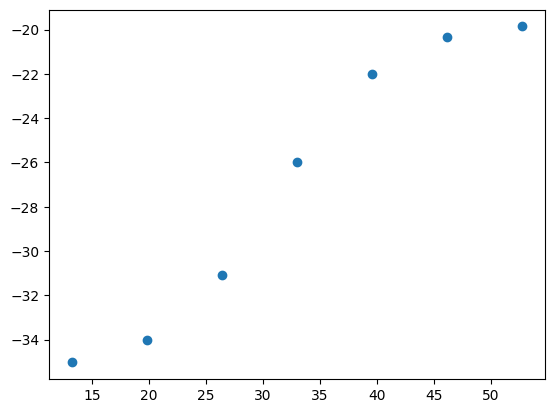

In [5]:
### Visuotactile experiment simulation setup

# Distance points in cm (network coordinates)
v_distances = np.asarray([13.2, 23.1, 33, 42.9, 52.8])
mydistances = np.linspace(v_distances[0], v_distances[-1], 7)

## Simulation setup
simtime = 100  # ms
bi = 0
g = 0.6

## Synapses setup
B_0 = 1.5
L_in, S_ex, S_in = 0.05, 1, 4

# Experimental Data
ymin = -35.42227065473723
ymax = -19.68086767326455
cp = 31.0507
slope = 4.8447

ASD_NS_RTs = RTsig(mydistances, cp, slope)
plt.scatter(mydistances, ASD_NS_RTs)

In [8]:
hcRTs, hc_qm, hc_qt, hc_qv = experimentrun_explore(
    mydistances, simtime, bi, g, 0.15, L_in, S_ex, S_in, B_0
)
asdRTs, asd_qm, asd_qt, asd_qv = experimentrun_explore(
    mydistances, simtime, bi, g, 0.63258857, L_in, S_ex, S_in, B_0
)

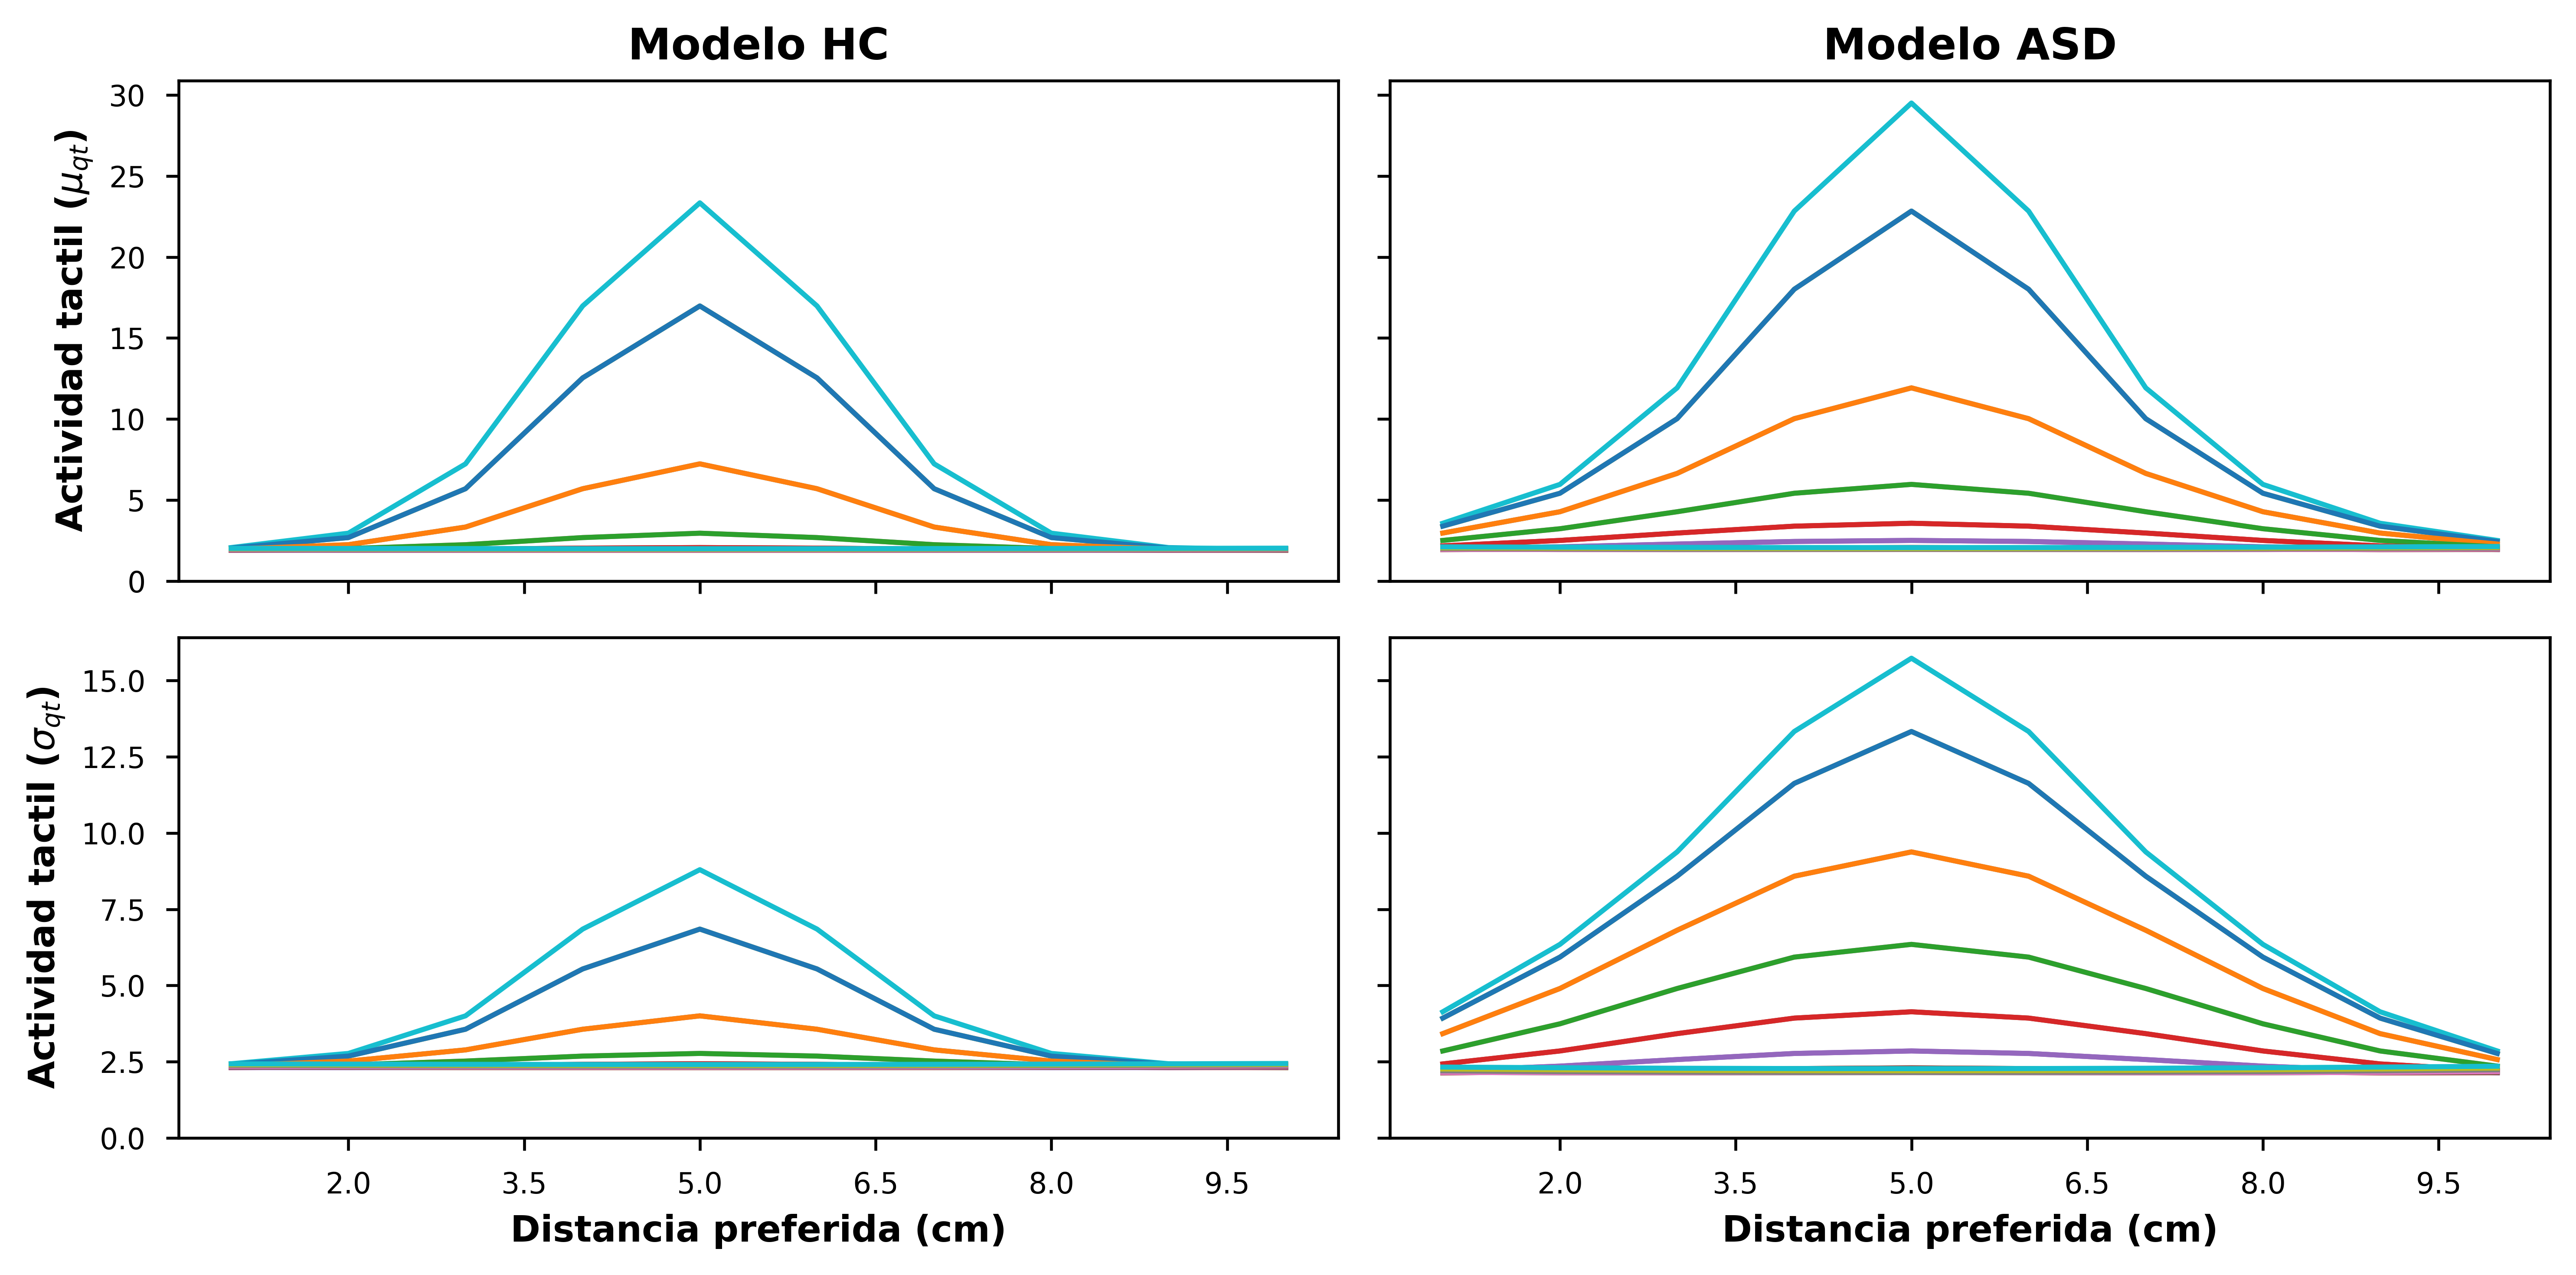

In [27]:
import string

plt.style.use("seaborn-v0_8-paper")

# initializes figure and plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey="row", dpi=600, sharex="all")


ax1 = plt.subplot(221)
ax1.plot(np.mean(hc_qt[:, :, :, 3], axis=2).T)
ax1.set_ylabel(r"Actividad tactil ($\mu_{qt}$)", size=10, weight="bold")
ax1.set_title("Modelo HC", weight="bold", size=12)
ax1.set_xticks(np.arange(-0.5, 9.5, 1.5))
ax1.set_xticklabels(np.arange(0.5, 10.5, 1.5))

ax2 = plt.subplot(222)
ax2.plot(np.mean(asd_qt[:, :, :, 3], axis=2).T)
ax2.set_title("Modelo ASD", weight="bold", size=12)
ax2.set_ylim(
    0,
)

ax3 = plt.subplot(223)
ax3.plot(np.std(hc_qt[:, :, :, 3], axis=2).T)
ax3.set_ylabel(r"Actividad tactil ($\sigma_{qt}$)", size=10, weight="bold")
ax3.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")

ax4 = plt.subplot(224)
ax4.plot(np.std(asd_qt[:, :, :, 3], axis=2).T)
ax4.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")
ax4.set_ylim(
    0,
)

plt.tight_layout()

fig.savefig("Results/FIG_Extra_1.eps", bbox_inches="tight", format="eps")
fig.savefig("Results/FIG_Extra_1.png", bbox_inches="tight")

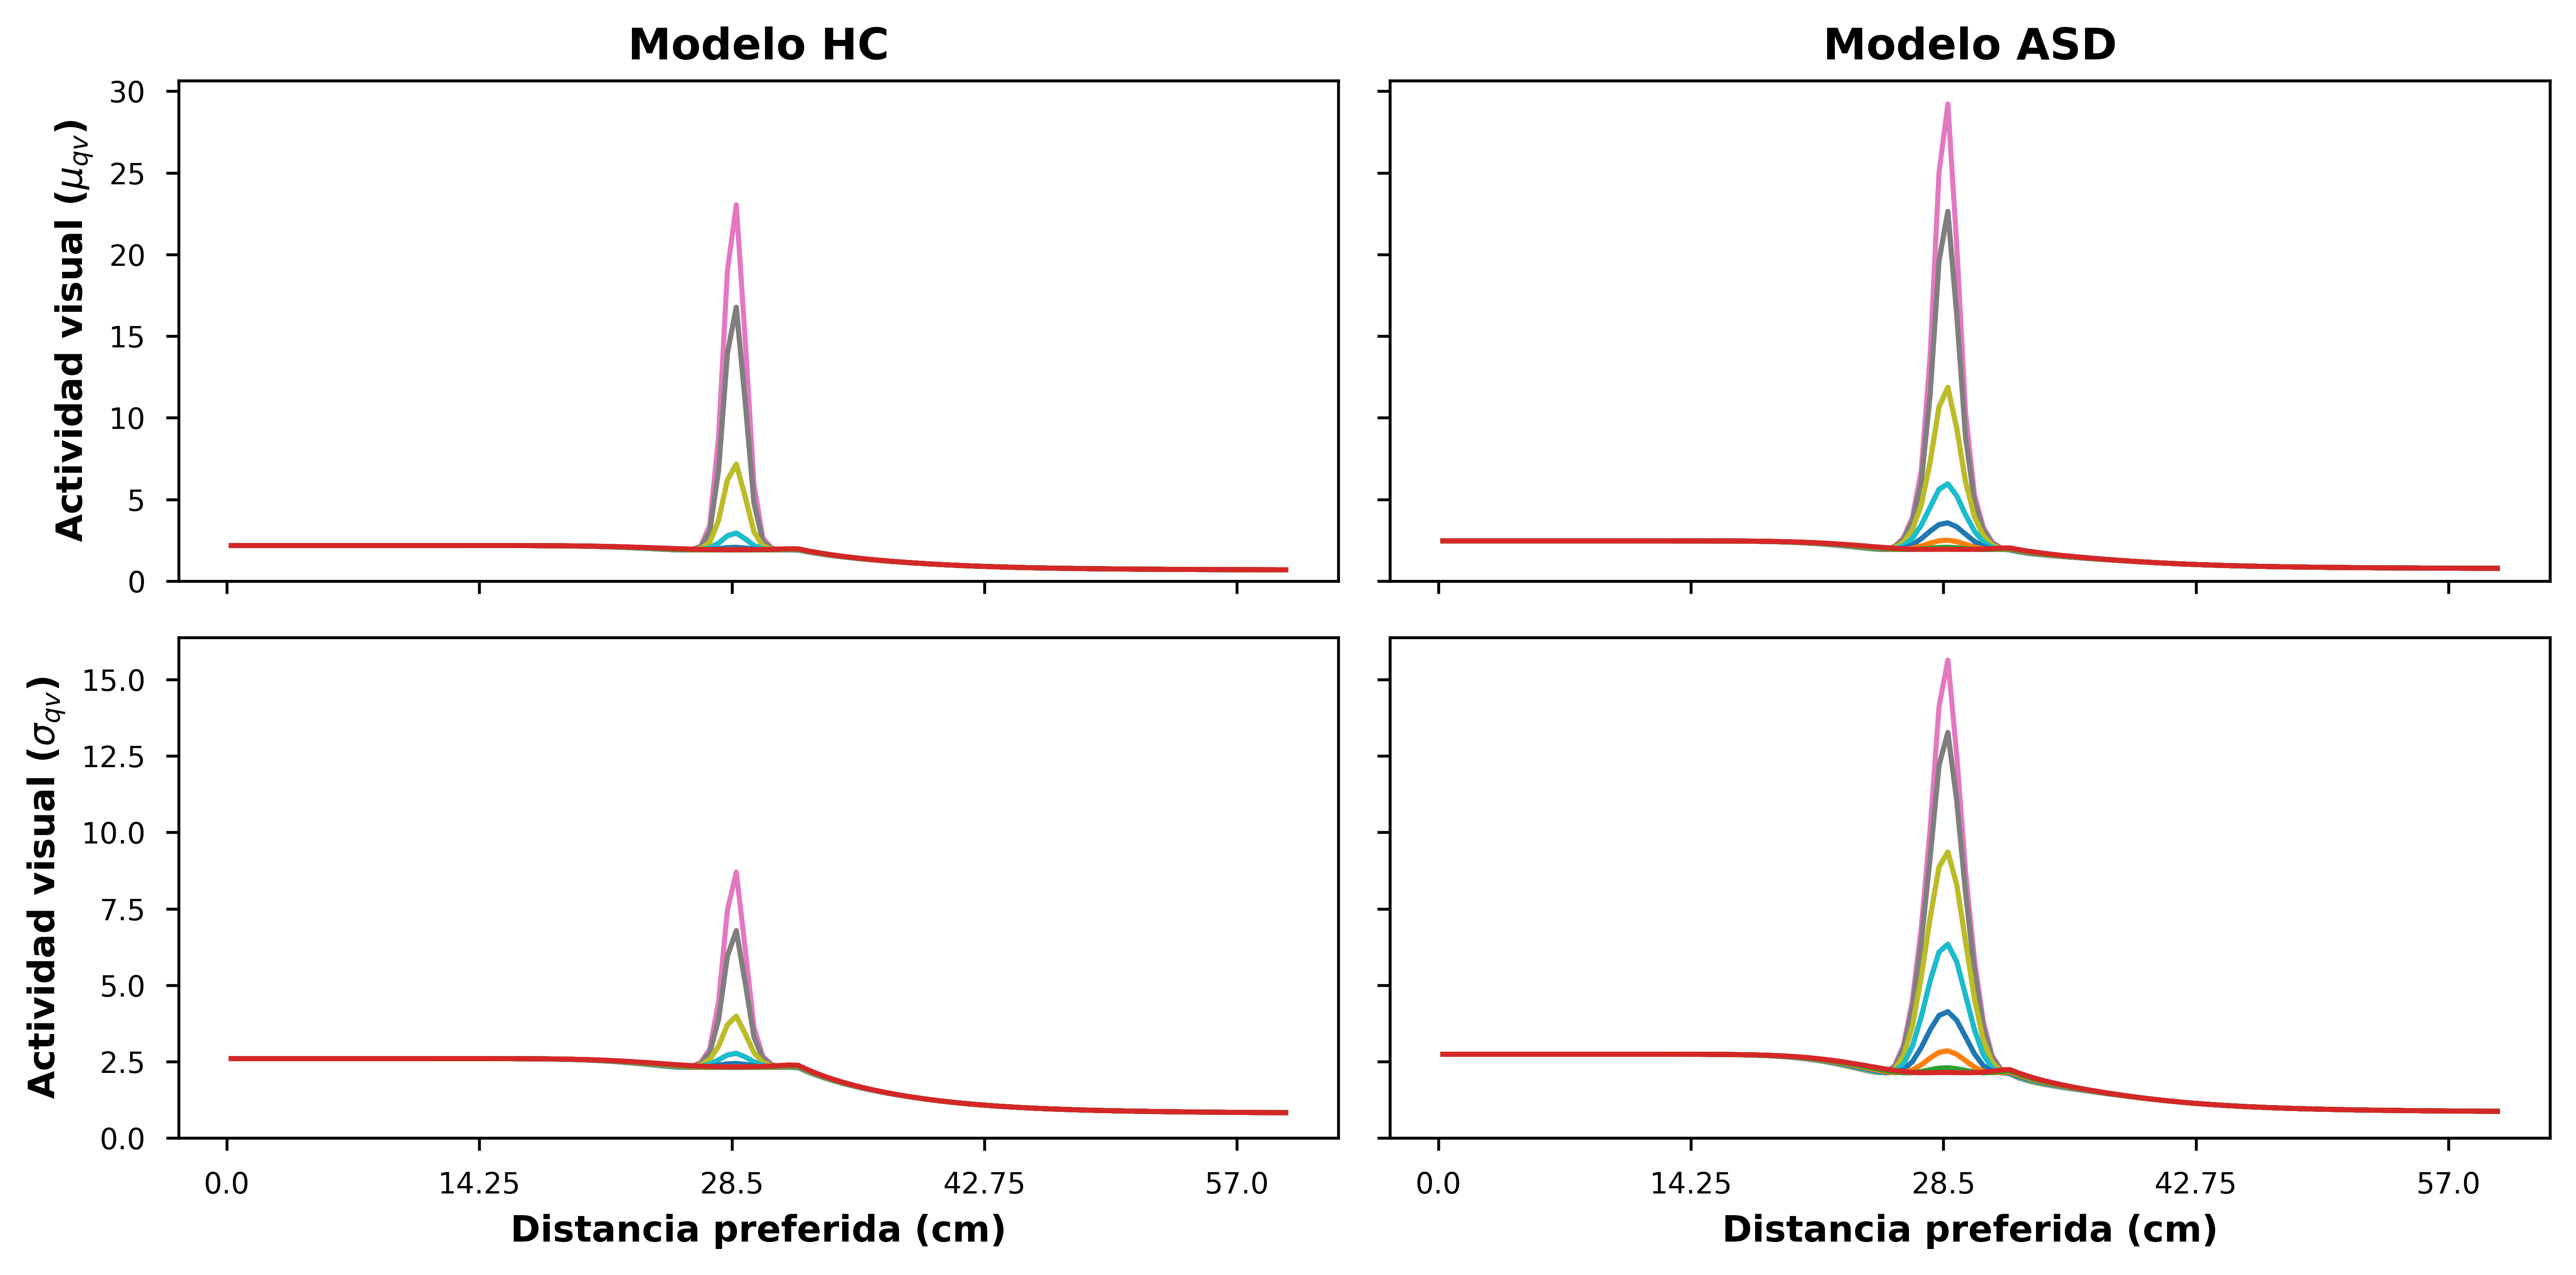

In [28]:
plt.style.use("seaborn-v0_8-paper")

# initializes figure and plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey="row", dpi=600, sharex="all")


ax1 = plt.subplot(221)
ax1.plot(np.mean(hc_qv[:, :, :, 3], axis=2))
ax1.set_ylabel(r"Actividad visual ($\mu_{qv}$)", size=10, weight="bold")
ax1.set_title("Modelo HC", weight="bold", size=12)
ax1.set_xticks(np.arange(-0.5, 119.5, 28.5))
ax1.set_xticklabels(np.arange(0, 60, 14.25))

ax2 = plt.subplot(222)
ax2.plot(np.mean(asd_qv[:, :, :, 3], axis=2))
ax2.set_title("Modelo ASD", weight="bold", size=12)
ax2.set_ylim(
    0,
)

ax3 = plt.subplot(223)
ax3.plot(np.std(hc_qv[:, :, :, 3], axis=2))
ax3.set_ylabel(r"Actividad visual ($\sigma_{qv}$)", size=10, weight="bold")
ax3.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")

ax4 = plt.subplot(224)
ax4.plot(np.std(asd_qv[:, :, :, 3], axis=2))
ax4.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")
ax4.set_ylim(
    0,
)

plt.tight_layout()

fig.savefig("Results/FIG_Extra_2.eps", bbox_inches="tight", format="eps")
fig.savefig("Results/FIG_Extra_2.png", bbox_inches="tight")